In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.linalg import orth
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.ticker import LogFormatter
from scipy.optimize import minimize, linprog
from scipy.optimize import differential_evolution, NonlinearConstraint
np.random.seed(29)
warnings.filterwarnings("ignore")

In [2]:
def generate_action_set(trials, iterations, M, num_action, d, k):
    
    Action_list = np.zeros((trials, iterations, M, num_action, d))
    Theta_list = np.zeros((trials, d, M))

    for T in range(trials):

        for m in range(M):

            Action_list[T, :, m, :, :] = np.random.randn(iterations, num_action, d)

        B_star = orth(np.random.rand(d, k))
        W_star = np.random.rand(k, M)
        Theta_star = np.dot(B_star, W_star)

        Theta_list[T] = Theta_star
        
    return Action_list, Theta_list

In [3]:
def init_altgdmin(X, t, Y, C, M, d, k, Theta_star):
    
    alpha = C * np.linalg.norm(Y, 'fro') / np.sqrt(t * M)
    Y_trunc = np.where(np.abs(Y) > alpha, 0, Y)
    
    Theta_0 = np.zeros((d, M))
    
    for i in range(M):
        
        Theta_0[:, i] = np.sum(X[i].dot(np.diag(Y_trunc[i])), axis=1) / t
    
    U_0, Sigma_0, V_0 = np.linalg.svd(Theta_0, full_matrices = False)
    B_hat = U_0[:, :k]
    S_k = np.zeros((k, k))
    np.fill_diagonal(S_k, Sigma_0[:k])
    error = np.linalg.norm(B_hat.dot(S_k).dot(V_0[:k, :]) - Theta_star, 'fro') / np.linalg.norm(Theta_star, 'fro')
    
    return B_hat, error

In [4]:
def AltGD_Min(X, Y, M, k, B_hat, Theta_star):
    
    W_hat = np.zeros((k, M))
    
    for i in range(M):

        W_hat[:, i] = np.linalg.lstsq(np.dot(X[i].T, B_hat), Y[i], rcond = None)[0]

    Theta_hat = np.dot(B_hat, W_hat)
    
    error = np.linalg.norm(Theta_star - Theta_hat, 'fro') / np.linalg.norm(Theta_star, 'fro')
    
    return W_hat, error

In [5]:
CR_Trials_ICML = []
d = 100
M = 40
k = 2
C = 6
trials = 100
sigma = 1e-3
delta = 1e-3
num_action = 10
epoch_iter = 45
iterations = 200
every_point = 25
A, Theta = generate_action_set(trials, iterations, M, num_action, d, k)

In [6]:
# generate the noise of reward for each iteration
noise_list = np.random.normal(0, sigma ** 2, size = (trials, iterations, M))

In [7]:
# ICML
start = time.time()

for T in tqdm(range(trials), desc = 'Trials'):
    
#     print('Trial:', T)
    
    action_set = A[T]
    Theta_star = Theta[T]
    noise_T = noise_list[T]
    
    B_hat = np.zeros((d, k))
    W_hat = np.zeros((k, M))
    Theta_hat = B_hat.dot(W_hat)
    
    cumulative_regret = 0
    cummulative_regret_list = [0]
    
    X = [np.empty((d, 0)) for _ in range(M)]
    Y = [np.empty(0) for _ in range(M)]
    
    for t in range(epoch_iter):
        
        for i in range(M):
            
            action = np.argmax(np.dot(action_set[t, i], Theta_hat[:, i]))
            reward = action_set[t, i, action].dot(Theta_star[:, i])
            cumulative_regret += np.max(np.dot(action_set[t, i], Theta_star[:, i])) - reward
            
            X[i] = np.hstack((X[i], action_set[t, i, action].reshape(-1, 1)))
            Y[i] = np.append(Y[i], reward + noise_T[t, i])
            
        cummulative_regret_list.append(cumulative_regret)
            
    B_hat, error = init_altgdmin(X, epoch_iter, Y, C, M, d, k, Theta_star)
    W_hat, error = AltGD_Min(X, Y, M, k, B_hat, Theta[T])
    Theta_hat = B_hat.dot(W_hat)
    
    for t in range(epoch_iter, iterations):
        
        for i in range(M):
            
            action = np.argmax(np.dot(action_set[t, i], Theta_hat[:, i]))
            reward = action_set[t, i, action].dot(Theta_star[:, i])
            cumulative_regret += np.max(np.dot(action_set[t, i], Theta_star[:, i])) - reward
            
        cummulative_regret_list.append(cumulative_regret)
        
#         print('t: {} regret: {} error: {}:'.format(num, regret, error))

    CR_Trials_ICML.append((T, cummulative_regret_list))
    
end = time.time()
print('Finished! The total time we use is: ', end - start)

Trials: 100%|██████████| 100/100 [00:11<00:00,  8.97it/s]

Finished! The total time we use is:  11.162917137145996


In [8]:
def prepare_plot_data(CR_Trials, iterations, trials):
    
    x_value = np.array([i for i in range(iterations + 1)])
    y_value = np.zeros(iterations + 1)
    
    for i in range(iterations + 1):
        
        for T in range(trials):
            
            y_value[i] += CR_Trials[T][1][i]
            
    y_value = y_value / trials
            
    return x_value, y_value

In [9]:
x_proposed, y_proposed = prepare_plot_data(CR_Trials_ICML, iterations, trials)

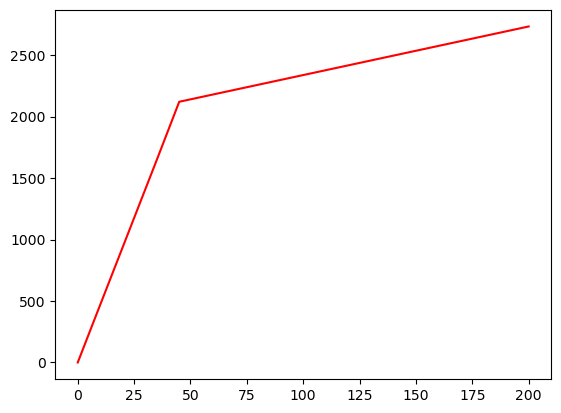

In [10]:
plt.plot(x_proposed, y_proposed, color = 'r')

In [11]:
np.save('CR_Trials_ICML.npy', np.array(CR_Trials_ICML, dtype=object))